# GRADED CHALLENGE 3

### Nama : Alexander Greateine Tanaku
### Batch : FTDS - 014

# Problem Statement

Kamu adalah anggota tim Data Science di Austin Smart City dan sedang mengerjakan projek analisa sistem pembuangan dan pengelolaan sampah di kota tersebut. Sebagai anggota tim, berdasarkan data yang tersedia, coba analisa data tersebut menggunakan statistik deskriptif dan inferensial, serta berikan insight kepada pemerintah kota Austin mengenai kondisi sistem pembuangan dan pengelolaan sampah. 

# Working Area

## Query Dataset dari GCP

SELECT 
load_time,
load_type,
load_weight,
dropoff_site
FROM `bigquery-public-data.austin_waste.waste_and_diversion` LIMIT 150000

## Importing Library

In [1]:
import pandas as pd
import scipy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta
from scipy import stats as st
from scipy. stats import skew
from scipy.stats import t
from statsmodels.graphics.gofplots import qqplot 
from scipy.stats import norm, uniform 

## Load dataset

In [2]:
df = pd.read_csv('h8dsft_P0GC3_Alexander_G.T.csv')
df.head()

,load_time,load_type,load_weight,dropoff_site
0,2009-08-07 11:51:00 UTC,RECYCLING - SINGLE STREAM,4400.0,MRF
1,2008-04-11 12:31:00 UTC,RECYCLING - PAPER,1920.0,MRF
2,2009-01-16 12:58:00 UTC,RECYCLING - SINGLE STREAM,4140.0,MRF
3,2009-07-10 11:21:00 UTC,RECYCLING - SINGLE STREAM,4020.0,MRF
4,2006-02-03 12:36:00 UTC,RECYCLING - COMINGLE,1700.0,MRF


In [3]:
df.tail()

,load_time,load_type,load_weight,dropoff_site
149995,2011-08-17 12:45:00 UTC,RECYCLING - SINGLE STREAM,13380.0,TDS - MRF
149996,2011-06-08 10:59:00 UTC,RECYCLING - SINGLE STREAM,14080.0,TDS - MRF
149997,2012-04-11 12:09:00 UTC,RECYCLING - SINGLE STREAM,14260.0,TDS - MRF
149998,2011-08-31 02:50:00 UTC,RECYCLING - SINGLE STREAM,4100.0,TDS - MRF
149999,2011-07-20 11:21:00 UTC,RECYCLING - SINGLE STREAM,6220.0,TDS - MRF


## Data Pre-processing

In [4]:
# Mengecheck missing value
df.isnull().sum()

load_time          0
load_type          0
load_weight     5066
dropoff_site       0
dtype: int64

In [5]:
df = df.dropna(axis = 0)

In [6]:
df.describe()

,load_weight
count,144934.000000
mean,7133.694944
std,4610.055367
min,-4480.000000
25%,3400.000000
50%,5800.000000
75%,11220.000000
max,75000.000000


Berdasar statistik dapat dilihat jika minimum dari load weight ada yang negatif, berat tidak mungkin negatif maka harus dihapus berat yang negatif tersebut menggunakan looping

In [7]:
df.drop(df.index[df['load_weight'] <= 0], inplace=True)

## Exploratory Data Analysis

In [8]:
df["load_time"] = pd.to_datetime(df["load_time"])

In [9]:
# Looking for period of datasets
a = df.load_time.max()
b = df.load_time.min()
time_diff = a - b
rdelta = relativedelta(a, b)
rdelta
print(f'Periode dari dataset ini adalah {rdelta}')

Periode dari dataset ini adalah relativedelta(years=+21, months=+5, days=+14, hours=+18, minutes=+28, seconds=+5)


In [10]:
# Melihat type waste pada load_type dari dataset
df.load_type.unique()

array(['RECYCLING - SINGLE STREAM', 'RECYCLING - PAPER',
       'RECYCLING - COMINGLE', 'SWEEPING', 'BRUSH', 'TIRES', 'BULK',
       'RECYCLED METAL', 'YARD TRIMMING', 'MIXED LITTER', 'ORGANICS',
       'GARBAGE COLLECTIONS', 'RECYCLING - PLASTIC BAGS', 'MULCH',
       'YARD TRIMMING - X-MAS TREES', 'CONTAMINATED RECYCLING',
       'DEAD ANIMAL', 'LITTER'], dtype=object)

In [11]:
# Melihat pembuangan data berdasar jenis load nya
df_group_load = df.groupby(by = 'load_type').sum()
df_group_load = df_group_load.reset_index()
df_group_load1= df_group_load.iloc[0:9,:]
df_group_load2 = df_group_load.iloc[10:17,:]

# Load_type Visualization

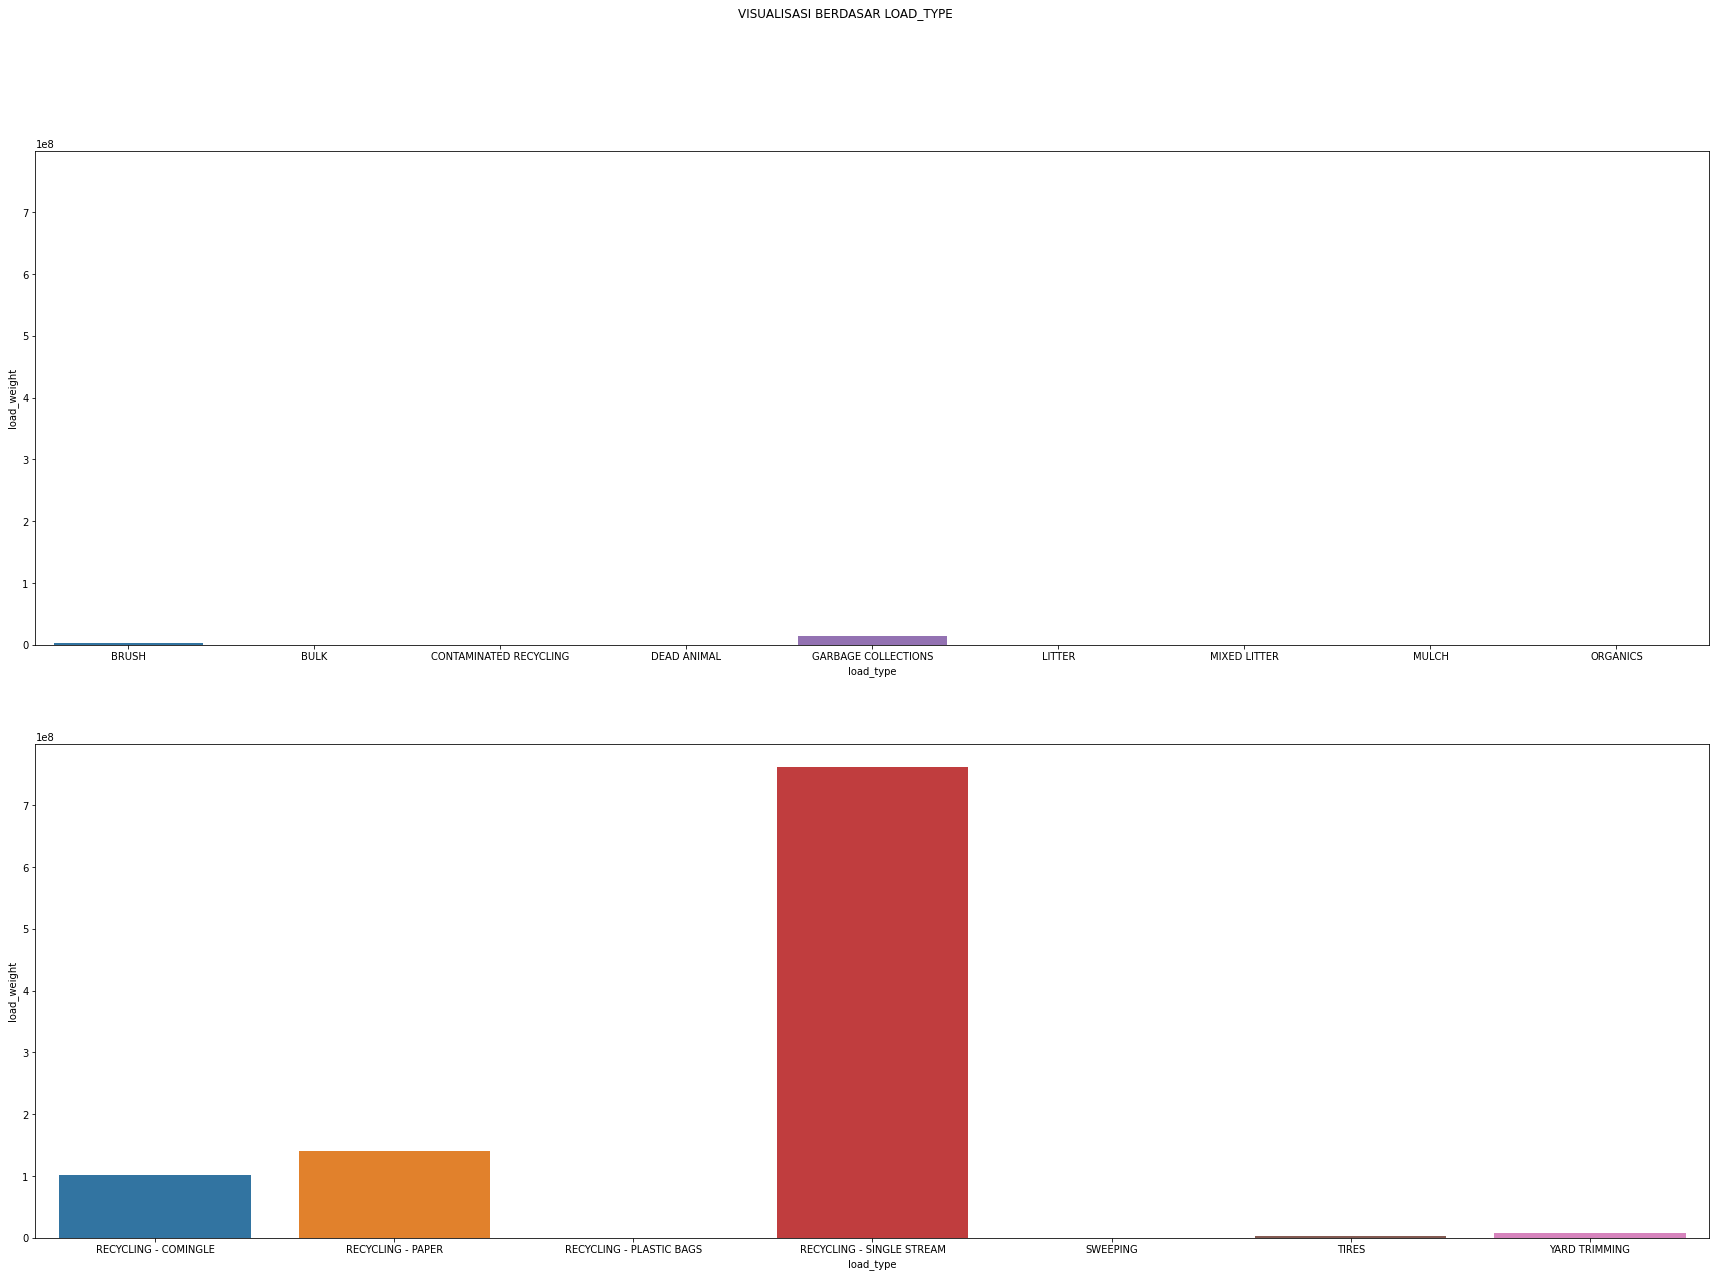

In [12]:
fig, axes = plt.subplots(2, 1, sharey = True)
fig.suptitle('VISUALISASI BERDASAR LOAD_TYPE')
sns.barplot(x="load_type", 
            y="load_weight", 
            data=df_group_load1,  
            ax = axes[0]
)
sns.barplot(x="load_type", 
            y="load_weight", 
            data=df_group_load2,  
            ax = axes[1]
)
plt.gcf().set_size_inches(30, 20)

Jika Dilihat dari load_type nya, terlihat jika kebanyakan jenis waste yang dibuang adala recycling - single stream jika dibandingkan dengan load_type yang lain. Beberapa load_type yang lain bahkan hanya terdapat sangat sedikit waste dari load_weightnya sampai tidak terlihat plotnya ketika divisualisasikan

In [13]:
# Range 
print(df.load_weight.max())
print(df.load_weight.min())

75000.0
20.0


# Data Analytics based on dropoff_site

In [14]:
# Melihat distribusi dari dataset

def plot_dist(df, col):
    fig, axes = plt.subplots(ncols = 2, figsize = (15, 5))
    
    # histogram
    sns.histplot(df[col],ax = axes[0], bins=30, kde=True,line_kws={'linewidth': 3},color = 'k')
    axes[0].set_title(f"Histogram '{col}'")
    axes[0].axvline(df[col].mean(), color = 'red', linestyle = 'dashed', label = 'mean')
    axes[0].axvline(df[col].median(), color = 'green', linestyle = 'dashed', label = 'median')
    axes[0].legend()
    
    # boxplot
    sns.boxplot(y=df[col], ax =  axes[1])
    axes[1].set_title(f"Boxplot '{col}'")
    
    plt.show()
    
    # skewness
    print(df[col].name + ' Kurtosis: ' + str(df[col].kurt()))
    print(df[col].name + ' Skewness: ' + str(df[col].skew()))
    if -0.5 <= df[col].skew() <= 0.5:
        print("Columns '{}' normal distribution".format(col))
    elif df[col].skew() > 0.5:
        print("Columns '{}' right skewed".format(col))
    elif df[col].skew() < -0.5:
        print("Columns '{}' left skewed".format(col))

In [15]:
df_col = df.columns.tolist()
df_col

['load_time', 'load_type', 'load_weight', 'dropoff_site']

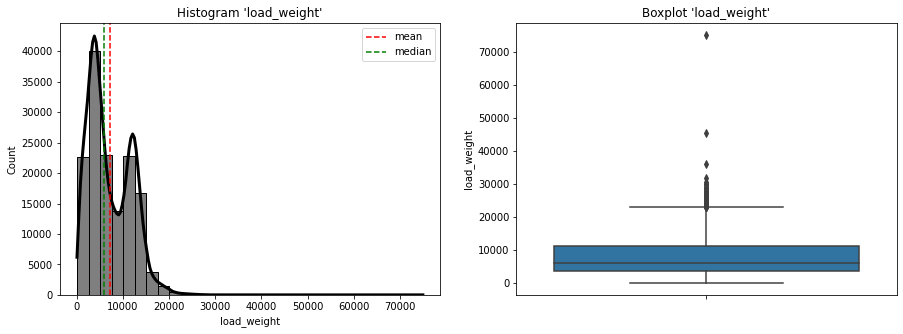

load_weight Kurtosis: -0.11208487896175523
load_weight Skewness: 0.5998051443364577
Columns 'load_weight' right skewed


In [16]:
plot_dist(df,df_col[2])

## Insight Based on Overall Central Tendency

Berdasarkan central tendency nya, ada beberapa penemuan menarik dari dataset austin_waste ini
1. Terdapat beberapa tempat di Austin yang load weightnya sangat tinggi yaitu diatas 70000
2. Data dari load weight 30000 sampai 70000 sangat sedikit dan grafiknya rata, artinya sedikit tempat yang load weightnya diatas dari 30000
3. Kebanyakan tempat di Austin load weightnya dibawah dari 10000
4. Range load_weight yang paling umum ada di sekitar 0 sampai 25000.

#### Membuat dataset untuk setiap dropoff site

In [17]:
df_clarkson = df[df['dropoff_site'] == "CLARKSON"].reset_index(drop = True)
df_elmont = df[df['dropoff_site'] == "ELMONT"].reset_index(drop = True)
df_kramer = df[df['dropoff_site'] == "KRAMER"].reset_index(drop = True)
df_mrf = df[df['dropoff_site'] == "MRF"].reset_index(drop = True)
df_park = df[df['dropoff_site'] == "PARK BEND"].reset_index()
df_tds = df[df['dropoff_site'] == "TDS - MRF"].reset_index(drop = True)
df_wilcab = df[df['dropoff_site'] == "WILCAB"].reset_index(drop = True)
df_zilker = df[df['dropoff_site'] == "ZILKER"].reset_index(drop = True)

list = [df_clarkson,df_elmont,df_kramer,df_mrf,df_park,df_tds,df_wilcab,df_zilker]

### Menyiapkan Grouping Data untuk Analisa 

In [18]:
df_group = df.groupby(by = 'dropoff_site').sum()
df_group.reset_index(inplace = True)
df_group

,dropoff_site,load_weight
0,CLARKSON,18640.0
1,ELMONT,76517.0
2,KRAMER,34980.0
3,MRF,475345737.0
4,PARK BEND,2901810.0
5,TDS - MRF,546569827.0
6,WILCAB,99200.0
7,ZILKER,8872712.0


## Dropoff Site Visualization

Text(0.5, 1.0, 'histogram ZILKER')

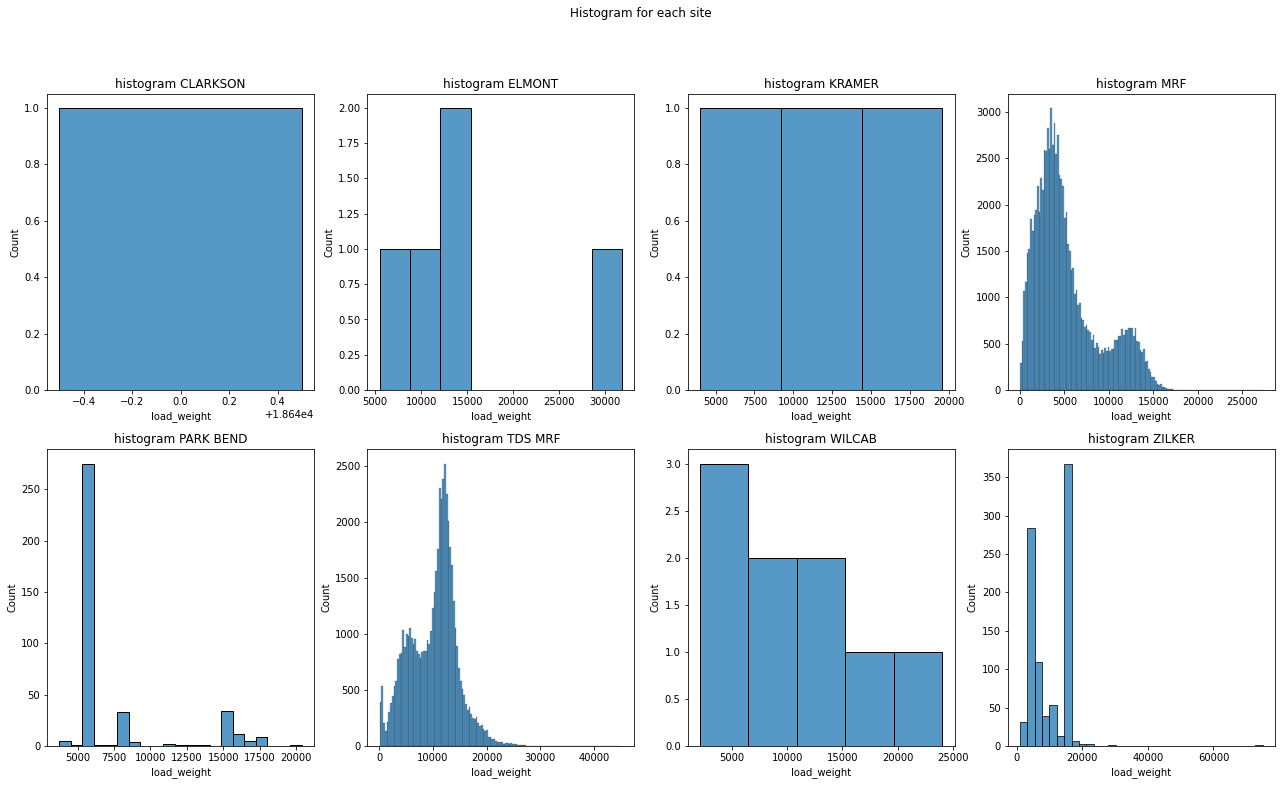

In [19]:
fig, axes = plt.subplots(2, 4, figsize=(22, 12))
fig.suptitle('Histogram for each site')
sns.histplot(ax=axes[0,0], x=df_clarkson['load_weight'])
sns.histplot(ax=axes[0,1], x=df_elmont['load_weight'])
sns.histplot(ax=axes[0,2], x=df_kramer['load_weight'])
sns.histplot(ax=axes[0,3], x=df_mrf['load_weight'])
sns.histplot(ax=axes[1,0], x=df_park['load_weight'])
sns.histplot(ax=axes[1,1], x=df_tds['load_weight'])
sns.histplot(ax=axes[1,2], x=df_wilcab['load_weight'])
sns.histplot(ax=axes[1,3], x=df_zilker['load_weight'])


axes[0,0].set_title("histogram CLARKSON")
axes[0,1].set_title("histogram ELMONT")
axes[0,2].set_title("histogram KRAMER")
axes[0,3].set_title("histogram MRF")
axes[1,0].set_title("histogram PARK BEND")
axes[1,1].set_title("histogram TDS MRF")
axes[1,2].set_title("histogram WILCAB")
axes[1,3].set_title("histogram ZILKER")

Berdasarkan plot dari setiap dropoff site, terlihat jika histogram TDS MRF dan histogram MRF memiliki paling banyak data. load_weight pada MRF maksimal sampai 25000 namun pada TDS MRF maksimal sampai 40000. jika dilihat dari persebaran datanya, MRF dan TDS MRF memiliki persebaran data yang berbeda, terlihat jika pada MRF load_weightnya kebanyakan ada di weight 5000 namun pada TDS MRF ada di 10000 sampai 20000. ini berarti weight yang ditaruh pada TDS MRF lebih berat rata-ratanya dibanding yang ditaruh di MRF

## Dropoff Site Central Tendency

In [20]:
for i in range(len(list)):
    a = list[i]['load_weight']
    b = list[i].iloc[0,3]
    print(f'Rata - rata dari site {b} = ' , np.mean(a))
    print(f'Median dari {b} =', np.median(a))
    x = st.mode(a)
    x = np.array(x)
    print(f'Modus dari {b} adalah = {x[0]} yang muncul sebanyak {x[1]} kali')
    print('-'*100)
    a = []

Rata - rata dari site CLARKSON =  18640.0
Median dari CLARKSON = 18640.0
Modus dari CLARKSON adalah = [18640.] yang muncul sebanyak [1.] kali
----------------------------------------------------------------------------------------------------
Rata - rata dari site ELMONT =  15303.4
Median dari ELMONT = 12560.0
Modus dari ELMONT adalah = [5480.] yang muncul sebanyak [1.] kali
----------------------------------------------------------------------------------------------------
Rata - rata dari site KRAMER =  11660.0
Median dari KRAMER = 11400.0
Modus dari KRAMER adalah = [3980.] yang muncul sebanyak [1.] kali
----------------------------------------------------------------------------------------------------
Rata - rata dari site MRF =  5313.737893489537
Median dari MRF = 4260.0
Modus dari MRF adalah = [3460.] yang muncul sebanyak [353.] kali
----------------------------------------------------------------------------------------------------
Rata - rata dari site 5840.0 =  7517.6424870466

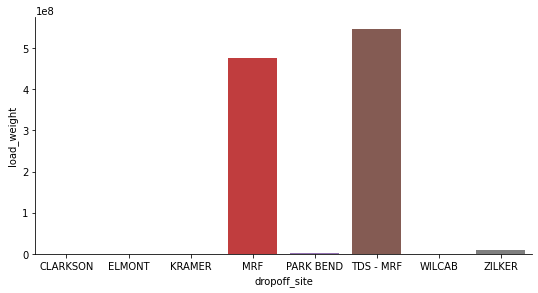

In [21]:
# Visualisasi berdasar group dropoff site
sns.catplot(x="dropoff_site", 
            y="load_weight", 
            data=df_group,  
            kind = 'bar',
)
plt.gcf().set_size_inches(8, 4)

Berdasarkan visualisasi grouping, dropoff site MRF dan TDS MRF memiliki data yang sangat banyak dibandingkan dengan dropoff site lainnya. site yang menarik untuk saya adalah TDS - MRF karena dropoff site itu memiliki data terbanyak dan rata - rata berat loadeweight yang lebih banyak dari MRF.

## Detecting and Handling The Outlier

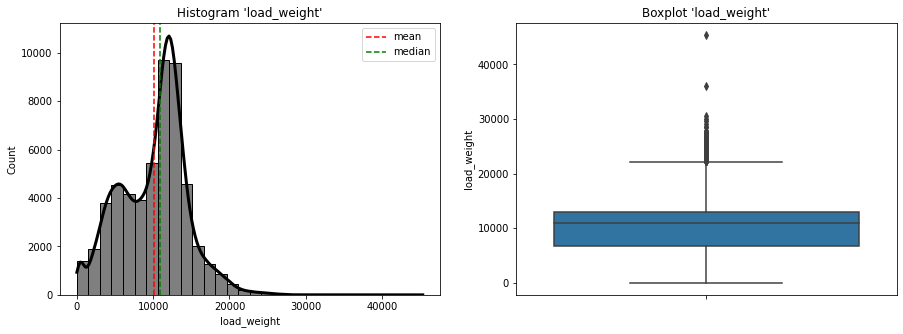

load_weight Kurtosis: 0.05650061893441949
load_weight Skewness: -0.03508097423207544
Columns 'load_weight' normal distribution


In [22]:
plot_dist(df_tds,'load_weight')

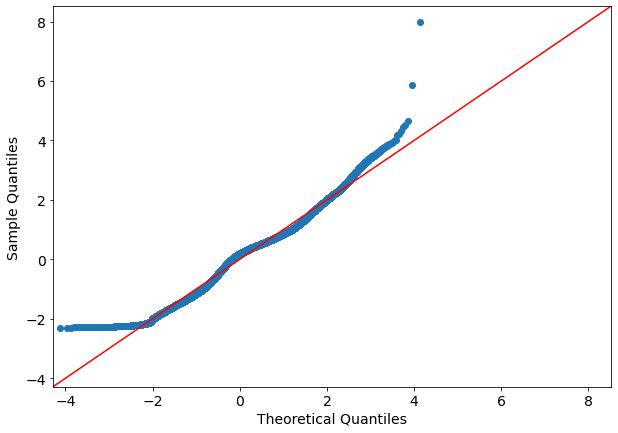

In [23]:
plt.rcParams['figure.figsize'] = [10, 7] 
plt.rc('font', size=14) 

x = df_tds.load_weight
qqplot(x,norm,fit=True,line="45") 
plt.show()

Persebaran data dari site TDS adalah normal distribution karena skewnessnya mendekati 0 maka bisa dibilang persebaran data ini lumayan symmetrical. Namun, jika dilihat dari boxplot load_weight nya, terdapat data outlier yang harus di bersihkan terlebih dahulu sebelum melakukan analisa data. Karena distribusinya normal, maka diputuskan untuk menghapus outliernya dengan method standard deviasi. Karena Data Scientist tidak percaya bahwa site TDS adalah normal distribution, maka dibuat lagi QQ plot untuk membuktikan bahwa distribusi data TDS adalah normal distribution

In [24]:
# Mencari mean dan standard deviasi pada dataset site tds
mean_tds = df_tds.load_weight.mean()
standard_dev = df_tds.load_weight.std()
print(mean_tds)
print(standard_dev)

10119.976800162936
4398.779244267689


In [25]:
upper_limit = mean_tds + 3*standard_dev
upper_limit

23316.314532966004

In [26]:
lower_limit = mean_tds - 3*standard_dev
lower_limit

-3076.360932640131

## Finding the Outlier

In [27]:
outliers = df_tds [(df_tds.load_weight < lower_limit) | (df_tds.load_weight > upper_limit)]
outliers

,load_time,load_type,load_weight,dropoff_site
6364,2012-10-05 05:35:00+00:00,GARBAGE COLLECTIONS,27300.0,TDS - MRF
6390,2015-05-21 12:38:00+00:00,GARBAGE COLLECTIONS,28600.0,TDS - MRF
6391,2011-06-16 01:16:00+00:00,GARBAGE COLLECTIONS,23800.0,TDS - MRF
6395,2021-05-20 11:28:00+00:00,GARBAGE COLLECTIONS,23940.0,TDS - MRF
6396,2021-02-25 11:39:00+00:00,GARBAGE COLLECTIONS,27760.0,TDS - MRF
...,...,...,...,...
40530,2013-07-30 02:16:00+00:00,RECYCLING - SINGLE STREAM,45305.0,TDS - MRF
44666,2021-06-01 02:32:00+00:00,RECYCLING - SINGLE STREAM,24340.0,TDS - MRF
46580,2012-03-20 01:38:00+00:00,RECYCLING - SINGLE STREAM,27020.0,TDS - MRF
52963,2019-07-10 03:54:00+00:00,RECYCLING - SINGLE STREAM,23320.0,TDS - MRF


### Outliers Percentage

In [28]:
outliers.count()

load_time       185
load_type       185
load_weight     185
dropoff_site    185
dtype: int64

In [29]:
df_tds.count()

load_time       54009
load_type       54009
load_weight     54009
dropoff_site    54009
dtype: int64

In [30]:
hasil = np.round(185/54009 * 100, 2)
print(f'data outliers dalam dataset site TDS - MRF ada sebanyak {hasil}%')

data outliers dalam dataset site TDS - MRF ada sebanyak 0.34%


## Making a Clean Dataset Without Outliers and Compare

In [31]:
df_tds_clean = df_tds [(df_tds.load_weight > lower_limit) & (df_tds.load_weight < upper_limit)]
df_tds_clean = df_tds_clean.reset_index(drop = True)

### Calculating Range, Variance, and Standard Deviasi load_weight to the selected site

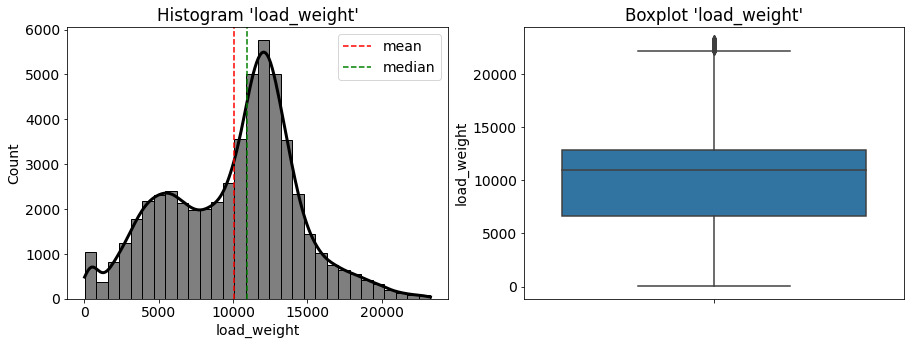

load_weight Kurtosis: -0.3123233265036931
load_weight Skewness: -0.15924569035080455
Columns 'load_weight' normal distribution


In [32]:
plot_dist(df_tds_clean, 'load_weight')

Setelah dilakukan pembersihan outlier, terlihat rangenya mengecil dan outliernya juga berkurang, namun setelah dilakukan boxplot, masih terdapat outlier, hal ini wajar karena IQRnya berubah dan itu adalah outlier baru. Namun sudah ditetapkan sebelumnya dari melihat skewness, persebaran data pada site TDS - MRF adalah persebaran data Gaussian, maka metode untuk menghapusnya menggunakan Standard Deviasi.

In [33]:
Range = df_tds.load_weight.max() - df_tds_clean.load_weight.min()
Range_2 = df_tds_clean.load_weight.max() - df_tds.load_weight.min()
print(f'Range pada data sebelum diremove outliersnya adalah {Range}')
print(f'Range pada data setelah diremove outliersnya adalah {Range_2}')

Range pada data sebelum diremove outliersnya adalah 45285.0
Range pada data setelah diremove outliersnya adalah 23260.0


In [34]:
print('Variance data sebelum diremove outliersnya adalah', df_tds.load_weight.var())
print('Variance data setelah diremove outliersnya adalah', df_tds_clean.load_weight.var())

Variance data sebelum diremove outliersnya adalah 19349258.839800224
Variance data setelah diremove outliersnya adalah 18615847.71564963


In [35]:
print('Standard Deviation data sebelum diremove outliersnya adalah', df_tds.load_weight.std())
print('Standard Deviation data setelah diremove outliersnya adalah', df_tds_clean.load_weight.std())

Standard Deviation data sebelum diremove outliersnya adalah 4398.779244267689
Standard Deviation data setelah diremove outliersnya adalah 4314.608639917372


### INSIGHT 

1. Data yang dipakai untuk analisa sekarang lebih akurat karena sudah menghapus data dengan kasus ekstrim, range data jadi mengecil karena data sudah menjadi lebih relevan dengan yang terjadi sesungguhnya di lapangan.
2. Data semakin terkluster mendekati nilai rata-rata dilihat dari nilai standard deviasinya yang mengecil
3. Data semakin akurat karena variance nya berkurang artinya membutuhkan lebih sedikit sample.

### Menghitung Confidence Interval

In [36]:
conf_inv = st.norm.interval(0.95, df_tds.load_weight.mean(), df_tds.load_weight.std())
np.round(conf_inv,2)

array([ 1498.53, 18741.43])

Data yang saya gunakan adalah data dari satu site yaitu site yang saya pilih TDS, hal ini saya lakukan karena data dari site TDS yang lebih banyak dibanding site yang lain dan data ini terdistribusi normal. Alasan kedua saya amemilih data dari hanya satu site adalah agar dapat mencontoh site TDS yang memiliki kapasitas tampung terbesar dibandingkan site lainnya

## Saran untuk pemerintah
Disarankan jika ingin membuat site baru agar dapat menampung load_weight sampai minimal 18741, jika lebih juga dipersilahkan tapi jangan dibawah 18741. angka ini didapat berdasar data dari salah satu site yang paling sering digunakan.

## Hypothesis testing

Saya sebagai Data Scientist mau melakukan testing bahwa load_weight tiap tahun bertambah banyak


**H0: μ2011 <= μ2010**

**H1: μ2011 > μ2010**

Null Hypothesis : Rata - Rata load_weight sampah pada tahun 2011 lebih kecil atau sama dengan rata - rata load_weight sampah di tahun 2010

Alternate Hypothesis : Rata - Rata load_weight sampah pada tahun 2011 lebih besar dari rata - rata load_weight sampah di tahun 2010

## Step 1 : make 2 dataset for each year

In [37]:
sampah_2010 = df[(pd.DatetimeIndex(df['load_time']).year == 2010)]

sampah_2011 = df[(pd.DatetimeIndex(df['load_time']).year == 2011)]

## Step 2 : find the mean

In [38]:
mean2010 = np.abs(sampah_2010['load_weight'].mean())
mean2011 = np.abs(sampah_2011['load_weight'].mean())
print(f'Rata - rata load sampah setiap harinya di tahun 2010 adalah: {mean2010}')
print(f'Rata - rata load sampah setiap harinya di tahun 2011 adalah: {mean2011}')

Rata - rata load sampah setiap harinya di tahun 2010 adalah: 9398.833479789104
Rata - rata load sampah setiap harinya di tahun 2011 adalah: 9982.289855072464


rata - rata di tahun 2011 lebih tinggi dari 2010, namun mari di check apakah perubahan tersebut signifikan atau tidak

## Menghitung p_value dan t_statnya

In [39]:
t_stat,p_val = st.ttest_1samp(sampah_2011['load_weight'], mean2010)
print(t_stat)
print(np.round(p_val,10))

11.319226342835993
0.0


## Penjelasan Hasil
P_value lebih kecil dari 0.05, artinya null hypothesis ato h0 di tolak, maka dapat dibilang bahwa load_weight setiap tahunnya bertambah secara signifikan sesuai dengan statistiknya. t-test juga menunjukkan hasil yang positif dan dapat diartikan bahwa kedua rata-rata memang berbeda secara statistik

## Analisa untuk pemerintah dari hypothesis testing

Berdasarkan Hypothesis Testing, dapat di bilang jika terdapat kenaikan load_weight dari tahun 2010 ke 2011 dan kemungkinan untuk setiap tahun kedepan. Terdapat kenaikan dari rata - rata load_weight juga sekitar 600 dari tahun 2010 - 2011.

# ANALYSIS CONCLUSION

Berdasarkan analisa yang dibuat terdapat beberapa Insight menarik dari dataset austin_waste ini
1. Kebanyakan type sampah yang dibuang adalah Recycling - Stream
2. Site - TDS - MRF adalah site yang paling banyak digunakan jika dilihat dari load_weight nya
3. Terdapat kenaikan rata-rata load_weight per tahunnya dari tahun 2010 - 2011
4. load_weight terberat adalah 75000
5. Range load_weight yang mendekati populasi untuk TDS - MRF adalah 1498 - 18741
6. Kebanyakan load_weight di Austin berada dibawah 10000

# Pertanyaan Conceptual

## Apa perbedaan statistik deskriptif dan inferensial?

Statistik Deskriptif adalah ilmu statistik yang mempelajari central tendency, variabilitas dan distribusi data sample atau populasi. Seperti namanya, statistik deskriptif mendeskripsikan seberapa besar variabilitas data, seberapa tersebar kah data itu dan central tendency nya seperti mean, median dan modus. Statistik Inferensial adalah ilmu statistik yang mencoba untuk men generalisasikan kelompok besar. statistik inferensial berhubungan dengan karakteristik data memberikan gambaran yang akurat tentang parameter yang sesuai dari seluruh populasi. Secara singkat statistik inferential mencari hubungan antar variabel, statistik deskriptif menjelaskan variabel itu sendiri

## Metrik pada central tendency apa yang tepat digunakan untuk menyimpulkan data yang terdistribusi normal dan tidak? Apakah sama atau berbeda?

Metrik pada Central Tendency untuk menyimpulkan data yang terdistribusi normal atau tidak adalah mean,median dan modus. sebuah data yang persebaran datanya terdistribusi normal secara perfect memiliki mean = median = modus, jika mean > median > modus, maka data kemungkinan skew ke kanan. jika sebaliknya terjadi maka data skew ke kiri. Mean data merupakan data yang paling mencerminkan skewness yang paling besar dibanding median dan modus 

## Teknik apa yang kamu pilih untuk handling outlier? jelaskan alasannya!
Teknik Standard Deviasi saya pilih untuk handling outlier, alasannya karena pada site yang saya pilih, skewnessnya -0.03 yang mendekati 0, ini berarti persebaran datanya adalah distribusi normal. saya mengambil 99.7% dari data  yang ada dalam range 3 standard deviations.

##  Apa konsep dibalik central tendency sehingga kita dapat menggunakannya untuk menyelesaikan langkah pada nomor 7?

Konsep dibalik central tendency untuk menyelesaikan masalah nomor 7 adalah mencari data dengan probabilitas tertinggi data aslinya berada agar ketika sample dari data itu diambil berulang, meannya mendekati ke mean yang sesungguhnya. pada soal nomor 7 saya memakai alpha 0.5 maka dari itu saya menghitung confidence interval 0.95. standard deviasi juga dicari dan dimasukkan kedalam sebuah rumus matematika agar dapat menghasilkan confidence interval

## Jelaskan jenis uji hipotesis apa yang kamu terapkan dan mengapa?

Saya menerapkan jenis uji hipotesis One Tailed Hypothesis Testing karena saya mau melihat apakah terdapat kenaikan load_weight dari tahun ke tahun. alasan saya menggunakan one tailed hypothesis testing adalah alternate hypothesis yang saya berikan adalah rata2 di tahun 2011 lebih besar dari 2010 yang berarti null hypothesisnya berada dalam 95% confidence interval yang mengatakan rata-rata load_weight 2011 berada lebih kecil atau sama dengan 2010.